# DS 340W PROJECT - HOUSE PRICE PREDICTION
Group 10: Brianna Malone, and Alvaro Tapia


In [1]:
# Importing all the necessary packages and files
# import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import warnings
# ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# Reading the datasets
data = pd.read_csv('data.csv', error_bad_lines=False)
data = data.drop('id', axis=1) #Removing unwanted column which is ID
data.head()

,TtlPrc,UntPrc,Year,Elvt,RmNum,HllNum,KchNum,BthNum,Lat,Lng,...,RstNum,RstDst,RtlNum,RtlDst,TrfV,AgrPct,DstPct,HppPct,SadPct,FeaPct
0,24660,82533,2010,1,4,1,1,3,40.006694,116.486687,...,100,150,55,279,0.000000,13,7,33,20,24
1,12000,67659,1999,1,3,2,0,2,39.979226,116.314551,...,100,208,52,397,23.570463,11,10,35,19,23
2,16500,67205,2007,1,4,2,1,2,39.973845,116.463587,...,100,238,38,446,41.096296,16,10,33,21,18
3,4430,74996,1985,0,2,1,1,1,39.962995,116.449455,...,100,187,41,357,36.396620,12,10,33,22,21
4,5500,32682,2003,1,3,2,1,2,39.943112,116.109599,...,88,180,32,478,0.000000,11,11,32,24,19


# Performing Feature Importance and Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier

z = data.drop('TtlPrc', axis=1)
y = data['TtlPrc']

# Create and fit a Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(z, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Create a DataFrame to store feature names and their importances
importance_df = pd.DataFrame({'Feature': z.columns, 'Importance': feature_importances})

# Sort the DataFrame by importance in ascending order
importance_df = importance_df.sort_values(by='Importance')

# Create a horizontal bar graph
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Random Forest)')
plt.show()

In [3]:
# Filtering and removing unneccesary parameters for the purpose of investigation
# Removing the number of amenities because it is ambiguous to say how many amenities are in a city, distance is more important.
# Only including number of touristic atractions because that is the only amenity does that have an impact
# Removing some emotion parameters (the least important) based on feature importance
df = data.drop(['Elvt', 'KchNum', 'HllNum', 'EdcNum', 'HthNum', 'RtlNum', 'RstNum', 'DstPct', 'AgrPct'], axis=1)
df.head(5)

,TtlPrc,UntPrc,Year,RmNum,BthNum,Lat,Lng,TspNum,TspDst,AtrNum,AtrDst,EdcDst,HthDst,RstDst,RtlDst,TrfV,HppPct,SadPct,FeaPct
0,24660,82533,2010,4,3,40.006694,116.486687,39,366,6,481,390,416,150,279,0.000000,33,20,24
1,12000,67659,1999,3,2,39.979226,116.314551,44,395,27,470,140,492,208,397,23.570463,35,19,23
2,16500,67205,2007,4,2,39.973845,116.463587,30,417,12,524,589,735,238,446,41.096296,33,21,18
3,4430,74996,1985,2,1,39.962995,116.449455,50,343,28,565,417,695,187,357,36.396620,33,22,21
4,5500,32682,2003,3,2,39.943112,116.109599,48,397,10,642,436,535,180,478,0.000000,32,24,19


# Correlation Matrix for Feature Comparison

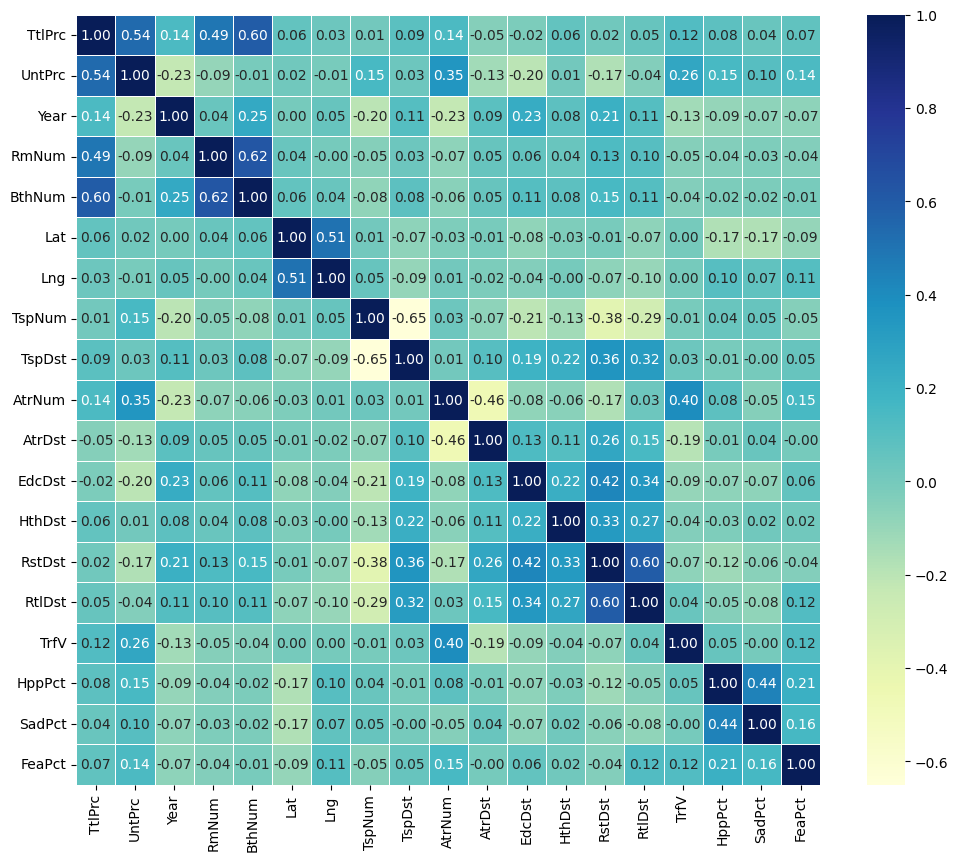

In [5]:
# Creating Correlation Matrix

import seaborn as sb

# create a correlation matrix of the features
corr_matrix = round(df.corr(), 2)

plt.figure(figsize=(12, 10))

# Create heatmap
sb.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=0.5)

# Show the plot
plt.show()

# Splitting process for modeling

In [6]:
from sklearn.model_selection import train_test_split

X = df.drop('TtlPrc', axis=1)
y = df['TtlPrc']

# Split the data into train, test, and validation sets
# Here, the code is splitted into training (70%), testing (15%), and validation (15%) sets.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

# Check the shapes of the resulting sets
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Train set shape: (21412, 18) (21412,)
Test set shape: (4282, 18) (4282,)
Validation set shape: (2856, 18) (2856,)


# Modeling with NEURAL NETWORKS

In [7]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Build the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for regression task
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val))

# Make predictions on the test set
y_test_pred = model.predict(X_test)

# Evaluate the model on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Evaluate the model on the validation set
nn_rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
nn_mae_val = mean_absolute_error(y_val, y_val_pred)

print(f'Test Set - Root Mean Squared Error (RMSE): {rmse_test}')
print(f'Test Set - Mean Absolute Error (MAE): {mae_test}')

print(f'Validation Set - Root Mean Squared Error (RMSE): {nn_rmse_val}')
print(f'Validation Set - Mean Absolute Error (MAE): {nn_mae_val}')




Epoch 1/50


670/670 [==============================] - 4s 3ms/step - loss: 26468002.0000 - mae: 2829.9590 - val_loss: 13930282.0000 - val_mae: 2349.2966
Epoch 2/50
670/670 [==============================] - 2s 3ms/step - loss: 12873981.0000 - mae: 2309.7878 - val_loss: 13908586.0000 - val_mae: 2334.7913
Epoch 3/50
670/670 [==============================] - 2s 3ms/step - loss: 12941319.0000 - mae: 2318.9846 - val_loss: 14433393.0000 - val_mae: 2614.2969
Epoch 4/50
670/670 [==============================] - 2s 3ms/step - loss: 12910072.0000 - mae: 2313.4270 - val_loss: 13836454.0000 - val_mae: 2344.1846
Epoch 5/50
670/670 [==============================] - 2s 3ms/step - loss: 12884865.0000 - mae: 2313.6531 - val_loss: 14059957.0000 - val_mae: 2256.8184
Epoch 6/50
670/670 [==============================] - 2s 3ms/step - loss: 12894266.0000 - mae: 2313.3977 - val_loss: 13829152.0000 - val_mae: 2334.3899
Epoch 7/50
670/670 [==============================] - 2s 3ms/step - loss: 12799911.

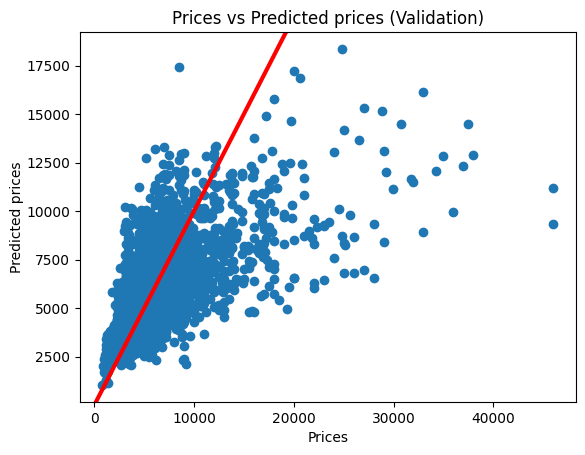

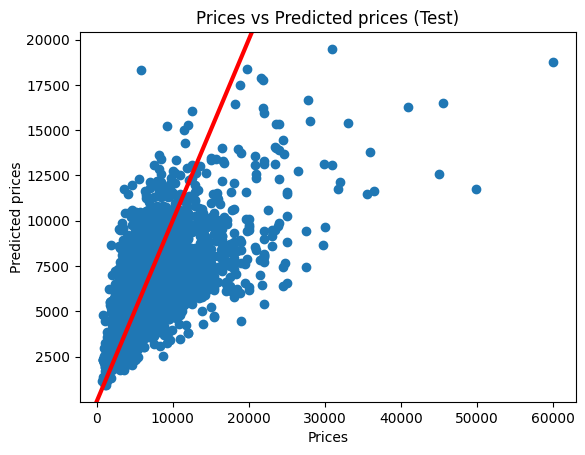

In [8]:
# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_val, y_val_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Validation)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Test)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Modeling with DECISION TREES

In [9]:
# Again if that doesnt work, use this code

from sklearn.tree import DecisionTreeRegressor

dt_regressor = DecisionTreeRegressor(random_state=42)

# Fit the model on the training data
dt_regressor.fit(X_train, y_train)

# Predict on the validation and test sets
y_val_pred = dt_regressor.predict(X_val)
y_test_pred = dt_regressor.predict(X_test)

# Calculate RMSE and MAE for the validation set
trees_rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))
trees_mae_val = mean_absolute_error(y_val, y_val_pred)

print("Validation RMSE:", trees_rmse_val)
print("Validation MAE:", trees_mae_val)

Validation RMSE: 2036.076236410658
Validation MAE: 986.9761904761905


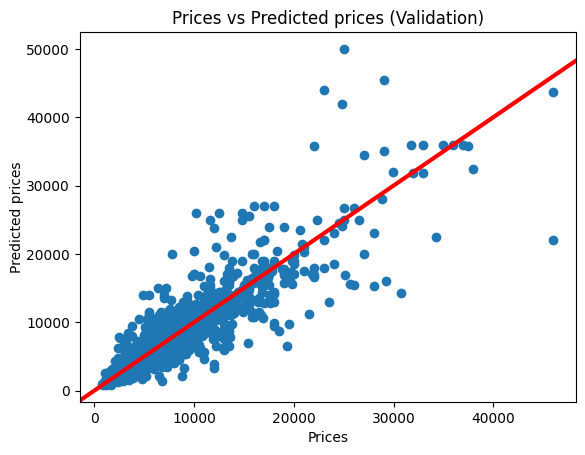

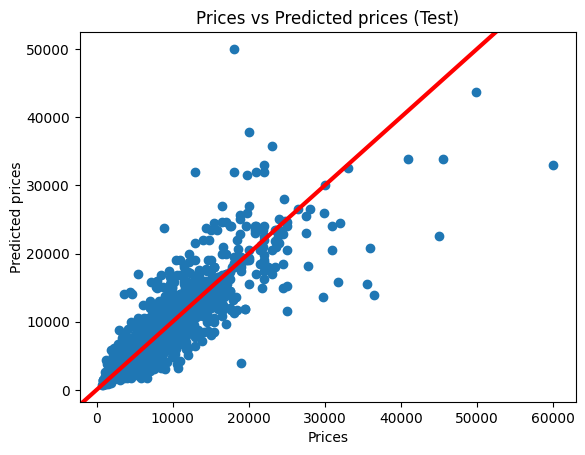

In [10]:
# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_val, y_val_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Validation)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Test)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Modeling for XGBOOST

In [11]:
from xgboost import XGBRegressor

# Create an XGBoost regressor model
xgb_regressor = XGBRegressor(random_state=42)

# Fit the model on the training data
xgb_regressor.fit(X_train, y_train)

# Predict on the validation and test sets
y_val_pred = xgb_regressor.predict(X_val)
y_test_pred = xgb_regressor.predict(X_test)

# Calculate RMSE and MAE for the validation set
XGB_rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))
XGB_mae_val = mean_absolute_error(y_val, y_val_pred)

print("Validation RMSE:", XGB_rmse_val)
print("Validation MAE:", XGB_mae_val)

Validation RMSE: 1399.420119680296
Validation MAE: 766.1259265333331


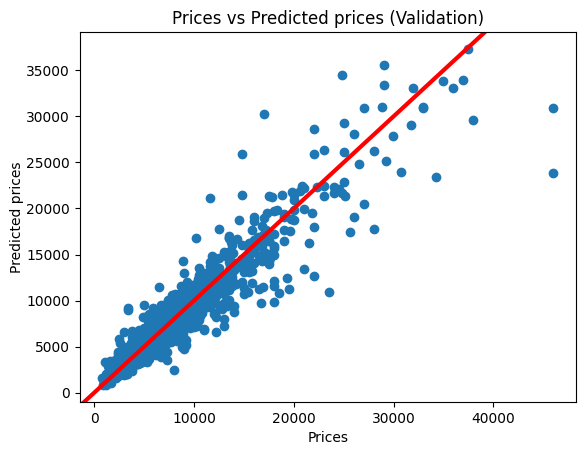

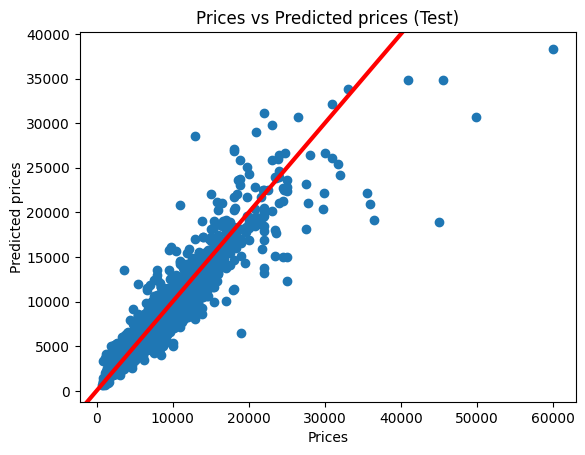

In [12]:
# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_val, y_val_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Validation)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Test)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Modeling for LOGISTIC REGRESSION

In [13]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
logistic_regression = LogisticRegression(random_state=42)

# Fit the model on the training data
logistic_regression.fit(X_train, y_train)

# Predict on the validation and test sets
y_val_pred = logistic_regression.predict(X_val)
y_test_pred = logistic_regression.predict(X_test)

# Calculate RMSE and MAE for the validation set
Log_rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))
Log_mae_val = mean_absolute_error(y_val, y_val_pred)

print("Validation RMSE:", Log_rmse_val)
print("Validation MAE:", Log_mae_val)

Validation RMSE: 3944.8910320694486
Validation MAE: 2324.9635854341736


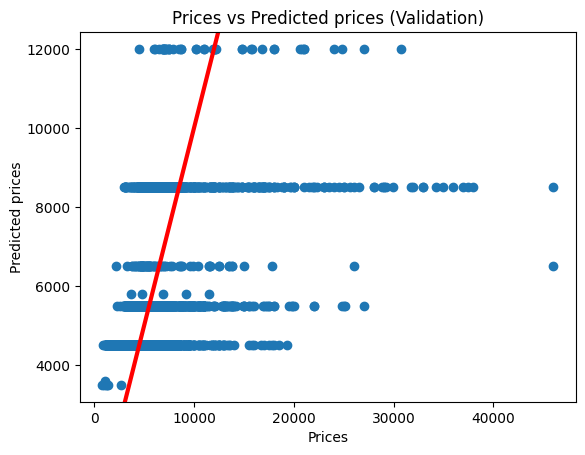

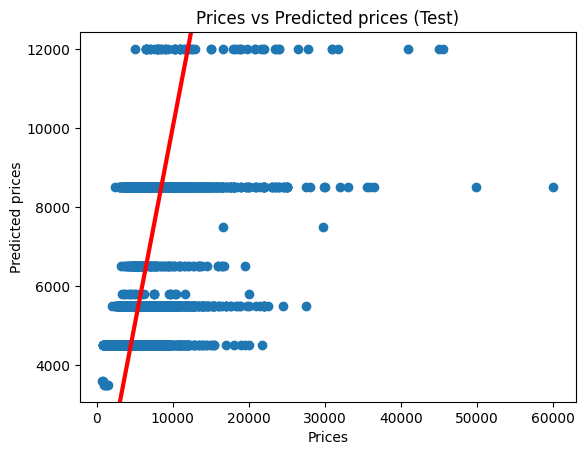

In [14]:
# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_val, y_val_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Validation)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Visualizing the differences between actual prices and predicted values
plt.clf()
plt.scatter(y_test, y_test_pred)
plt.xlabel("Prices")
plt.ylabel("Predicted prices", labelpad=1.5)
plt.title("Prices vs Predicted prices (Test)")
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='-', color='r', lw=3, scalex=False, scaley=False)
plt.show()

# Models Comparison

In [27]:
# Comparin the model results in a table

from tabulate import tabulate

model_names = ['Neural Networks', 'Decision Trees', 'XGBoost Reg', 'Logistic Reg']
rmse_results = [nn_mae_val, trees_rmse_val, XGB_rmse_val, Log_rmse_val]
mae_results = [nn_rmse_val, trees_mae_val, XGB_mae_val, Log_mae_val]

results = []

for name, rmse, mae in zip(model_names, rmse_results, mae_results):
    results.append([name, rmse, mae])

# Create a DataFrame for the results
columns = ['Model', 'RMSE', 'MAE']
results_df = pd.DataFrame(results, columns=columns)

# Find the index of the minimum RMSE and MAE
min_rmse_index = results_df['RMSE'].idxmin()
min_mae_index = results_df['MAE'].idxmin()

# Apply styling to the DataFrame
styled_df = results_df.style \
    .set_table_styles([{
        'selector': 'thead',
        'props': [('background', '#606060'), ('color', 'white')]
    }]) \
    .applymap(lambda x: 'background-color: green', subset=pd.IndexSlice[[min_rmse_index, min_mae_index], ['RMSE', 'MAE']])

# Render the styled DataFrame as HTML
display(styled_df)

,Model,RMSE,MAE
0,Neural Networks,2161.436917,3553.856965
1,Decision Trees,2036.076236,986.976190
2,XGBoost Reg,1399.420120,766.125927
3,Logistic Reg,3944.891032,2324.963585
